In [ ]:
import tensorflow as tf

# Clear any existing GPU settings
tf.keras.backend.clear_session()

# Set TensorFlow to run on GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Allow memory growth to prevent OOM (Out-of-Memory) errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set up successfully!")
    except RuntimeError as e:
        print(f"GPU Setup Error: {e}")



In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from PIL import Image
import shutil

In [2]:
# Define dataset paths
dataset1_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
dataset2_path = "/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
combined_dataset_path = "/kaggle/working/Combined_Lung_Dataset"

# Mapping folders to 3-class structure
datasets = {
    "lung_n": "Normal",
    "Normal cases": "Normal",
    "Bengin cases": "Benign",
    "lung_aca": "Malignant",
    "lung_scc": "Malignant",
    "Malignant cases": "Malignant",
}

# Make sure combined class folders exist
for category in set(datasets.values()):
    os.makedirs(os.path.join(combined_dataset_path, category), exist_ok=True)

# Function to copy & rename images with prefix
def copy_images(source_folder, target_folder, prefix):
    if os.path.exists(source_folder):
        for file in os.listdir(source_folder):
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                src_path = os.path.join(source_folder, file)
                new_filename = f"{prefix}_{file}"
                dst_path = os.path.join(target_folder, new_filename)
                shutil.copy(src_path, dst_path)

# Copy dataset 1 (H&E histology) → add "histo_" prefix
for folder, category in datasets.items():
    source_folder = os.path.join(dataset1_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder, prefix="histo")

# Copy dataset 2 (CT scans) → add "ct_" prefix
for folder, category in datasets.items():
    source_folder = os.path.join(dataset2_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder, prefix="ct")

# Cleanup: remove any empty folders
for category in set(datasets.values()):
    target_folder = os.path.join(combined_dataset_path, category)
    if len(os.listdir(target_folder)) == 0:
        print(f"Removing empty folder: {target_folder}")
        shutil.rmtree(target_folder)

print("✅ Dataset successfully merged into 3 classes: Normal, Benign, Malignant with histo/ct prefixes!")


✅ Dataset successfully merged into 3 classes: Normal, Benign, Malignant with histo/ct prefixes!


In [9]:
import os
import shutil

# === Paths ===
real_benign = "/kaggle/working/Combined_Lung_Dataset/Benign"
synthetic_benign = "/kaggle/input/gan-images-iq-othnccd-benign"
target_non_malignant = "/kaggle/working/Combined_Lung_Dataset/Non-Malignant"

# Create target folder
os.makedirs(target_non_malignant, exist_ok=True)

# === Copy Real Benign Images (prefix: real_) ===
for filename in os.listdir(real_benign):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(real_benign, filename)
        dst = os.path.join(target_non_malignant, f"real_{filename}")
        shutil.copyfile(src, dst)

# === Copy Synthetic Benign Images (prefix: ct_synthetic_) ===
for filename in os.listdir(synthetic_benign):
    if filename.lower().endswith('.png'):  # All synthetic are .png
        src = os.path.join(synthetic_benign, filename)
        dst = os.path.join(target_non_malignant, f"ct_synthetic_{filename}")
        shutil.copyfile(src, dst)

print(f"✅ Combined Real + Synthetic Benign images into: {target_non_malignant}")
print(f"🧾 Total: {len(os.listdir(target_non_malignant))} images")


✅ Combined Real + Synthetic Benign images into: /kaggle/working/Combined_Lung_Dataset/Non-Malignant
🧾 Total: 5120 images


In [10]:
# === Define paths ===
root_dataset = "/kaggle/working/Combined_Lung_Dataset"
normal_dir = os.path.join(root_dataset, "Normal")
benign_combined_dir = os.path.join(root_dataset, "Non-Malignant")  # this contains real + synthetic Benign
malignant_dir = os.path.join(root_dataset, "Malignant")

# Final binary class folder
final_dataset = "/kaggle/working/Final_Binary_Dataset"
final_non_malignant = os.path.join(final_dataset, "Non-Malignant")
final_malignant = os.path.join(final_dataset, "Malignant")

# === Create directories ===
os.makedirs(final_non_malignant, exist_ok=True)
os.makedirs(final_malignant, exist_ok=True)

# === Copy Normal images to Non-Malignant ===
for file in os.listdir(normal_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(normal_dir, file)
        dst = os.path.join(final_non_malignant, f"normal_{file}")
        shutil.copyfile(src, dst)

# === Copy Benign (real + synthetic) to Non-Malignant ===
for file in os.listdir(benign_combined_dir):
    if file.lower().endswith('.png') or file.lower().endswith(('.jpg', '.jpeg')):
        src = os.path.join(benign_combined_dir, file)
        dst = os.path.join(final_non_malignant, file)
        shutil.copyfile(src, dst)

# === Copy Malignant images ===
for file in os.listdir(malignant_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(malignant_dir, file)
        dst = os.path.join(final_malignant, file)
        shutil.copyfile(src, dst)

print("✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset")
print(f"📁 Non-Malignant: {len(os.listdir(final_non_malignant))} images")
print(f"📁 Malignant: {len(os.listdir(final_malignant))} images")


✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset
📁 Non-Malignant: 10536 images
📁 Malignant: 10561 images


In [11]:
import os
import numpy as np

image_paths = []
labels = []
label_dict = {}
data_dir = "/kaggle/working/Final_Binary_Dataset"
for idx, class_name in enumerate(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label_dict[class_name] = idx
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            image_paths.append(file_path)
            labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("✅ Loaded image paths and labels.")
print("🔢 Label Mapping:", label_dict)
print("📦 Total Images:", len(image_paths))



✅ Loaded image paths and labels.
🔢 Label Mapping: {'Malignant': 0, 'Non-Malignant': 1}
📦 Total Images: 21097


In [12]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = "/kaggle/working/Final_Binary_Dataset"
np.random.seed(42)

image_paths = []
labels = []
synthetic_paths = []
synthetic_labels = []
label_dict = {}

# === Load image paths and separate synthetic ===
for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label_dict[class_name] = idx
        for file in os.listdir(class_dir):
            full_path = os.path.join(class_dir, file)
            if class_name == "Non-Malignant" and file.startswith("synthetic_"):
                synthetic_paths.append(full_path)
                synthetic_labels.append(idx)
            else:
                image_paths.append(full_path)
                labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)
synthetic_paths = np.array(synthetic_paths)
synthetic_labels = np.array(synthetic_labels)

# === Split real data into 70% train, 20% val, 10% test ===
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.1, stratify=labels, random_state=42)

X_train_real, X_val, y_train_real, y_val = train_test_split(
    X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)  # 2/9 of 90% → ~20%

# === Add synthetic data to training set only ===
X_train = np.concatenate((X_train_real, synthetic_paths))
y_train = np.concatenate((y_train_real, synthetic_labels))

# === Done ===
print("✅ 70/20/10 Split complete (synthetic used only in training).")
print(f"📦 Training Set: {len(X_train)} images (with synthetic)")
print(f"🧪 Validation Set: {len(X_val)} images (real only)")
print(f"🧫 Test Set: {len(X_test)} images (real only)")


✅ 70/20/10 Split complete (synthetic used only in training).
📦 Training Set: 14767 images (with synthetic)
🧪 Validation Set: 4220 images (real only)
🧫 Test Set: 2110 images (real only)


In [13]:
import numpy as np
from collections import Counter

def print_distribution(y, name=""):
    counts = Counter(y)
    total = len(y)
    print(f"📊 {name} Set Distribution:")
    for label, count in sorted(counts.items()):
        percentage = (count / total) * 100
        print(f"  Class {label} → {count} samples ({percentage:.2f}%)")
    print(f"  Total: {total} images\n")

# Example:
print_distribution(y_train, "Train")
print_distribution(y_val, "Validation")
print_distribution(y_test, "Test")


📊 Train Set Distribution:
  Class 0.0 → 7392 samples (50.06%)
  Class 1.0 → 7375 samples (49.94%)
  Total: 14767 images

📊 Validation Set Distribution:
  Class 0 → 2113 samples (50.07%)
  Class 1 → 2107 samples (49.93%)
  Total: 4220 images

📊 Test Set Distribution:
  Class 0 → 1056 samples (50.05%)
  Class 1 → 1054 samples (49.95%)
  Total: 2110 images



In [14]:
# Parameters
image_size = (256, 256)
mean = tf.convert_to_tensor([0.485, 0.456, 0.406], dtype=tf.float32)
std = tf.convert_to_tensor([0.229, 0.224, 0.225], dtype=tf.float32)

In [15]:
'''
@tf.function
def augment_image(image, label):
    # Random Flip (Left-Right & Up-Down)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Rotation (0°, 90°, 180°, 270°)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random Saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_jpeg_quality(image, min_jpeg_quality=70, max_jpeg_quality=100)  # JPEG compression simulation

    # Add Gaussian Noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01, dtype=tf.float32)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)

    return image, label
    '''

'\n@tf.function\ndef augment_image(image, label):\n    # Random Flip (Left-Right & Up-Down)\n    image = tf.image.random_flip_left_right(image)\n    image = tf.image.random_flip_up_down(image)\n\n    # Random Rotation (0°, 90°, 180°, 270°)\n    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)\n    image = tf.image.rot90(image, k=k)\n\n    # Random Brightness and Contrast\n    image = tf.image.random_brightness(image, max_delta=0.1)\n    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)\n\n    # Random Saturation\n    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)\n    image = tf.image.random_jpeg_quality(image, min_jpeg_quality=70, max_jpeg_quality=100)  # JPEG compression simulation\n\n    # Add Gaussian Noise\n    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01, dtype=tf.float32)\n    image = tf.clip_by_value(image + noise, 0.0, 1.0)\n\n    return image, label\n    '

In [16]:
'''
@tf.function
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_contrast(image, 0.8, 1.2)
    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_saturation(image, 0.8, 1.2)

    if tf.random.uniform([]) > 0.5:
        image = tf.image.random_jpeg_quality(image, 70, 100)

    if tf.random.uniform([]) > 0.5:
        image = tf.image.central_crop(image, 0.8)
        image = tf.image.resize(image, [256, 256])

    # Add noise
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.01)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # Normalize
    image = tf.image.per_image_standardization(image)

    return image, label
'''

'\n@tf.function\ndef augment_image(image, label):\n    image = tf.image.random_flip_left_right(image)\n    image = tf.image.random_flip_up_down(image)\n\n    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)\n    image = tf.image.rot90(image, k)\n\n    if tf.random.uniform([]) > 0.5:\n        image = tf.image.random_brightness(image, max_delta=0.1)\n    if tf.random.uniform([]) > 0.5:\n        image = tf.image.random_contrast(image, 0.8, 1.2)\n    if tf.random.uniform([]) > 0.5:\n        image = tf.image.random_saturation(image, 0.8, 1.2)\n\n    if tf.random.uniform([]) > 0.5:\n        image = tf.image.random_jpeg_quality(image, 70, 100)\n\n    if tf.random.uniform([]) > 0.5:\n        image = tf.image.central_crop(image, 0.8)\n        image = tf.image.resize(image, [256, 256])\n\n    # Add noise\n    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.01)\n    image = tf.clip_by_value(image + noise, 0.0, 1.0)\n\n    # Normalize\n    image = tf.image.per_image

In [17]:
@tf.function
def augment_image(image, label, filename):
    # Apply base spatial transforms to all images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if tf.random.uniform([]) > 0.7:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)

    # === Conditional Augmentations ===
    # For histopathology images (H&E)
    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_brightness(image, max_delta=0.08)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_contrast(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_saturation(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.9:
            image = tf.image.random_jpeg_quality(image, 80, 100)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.central_crop(image, 0.9)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.7:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.005)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # For CT/synthetic images
    elif tf.strings.regex_full_match(filename, ".*ct.*|.*synthetic.*"):
        # Less aggressive augmentations
        if tf.random.uniform([]) > 0.8:
            image = tf.image.central_crop(image, 0.95)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.8:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.002)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    return image, label


In [18]:
# ================= Preprocessing Function ================= #
def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    print("Before normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = img / 255.0  # Normalize pixel values
    print("After division by 255:", tf.reduce_min(img), tf.reduce_max(img))
    # Apply augmentation only if augment=True
    if augment:
        img, label = augment_image(img, label, filename)
    print("After mean/std normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = (img - mean) / std  # Apply mean-std normalization
    img = tf.cast(img, tf.float32)
    return img, label

In [19]:
# ================= Dataset Creation ================= #
def create_dataset(image_paths, labels, batch_size=32, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [20]:
# Create datasets
train_dataset = create_dataset(X_train, y_train, augment=True)  # Augmentation only in training
val_dataset = create_dataset(X_val, y_val, shuffle=False)
test_dataset = create_dataset(X_test, y_test, shuffle=False)


Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)


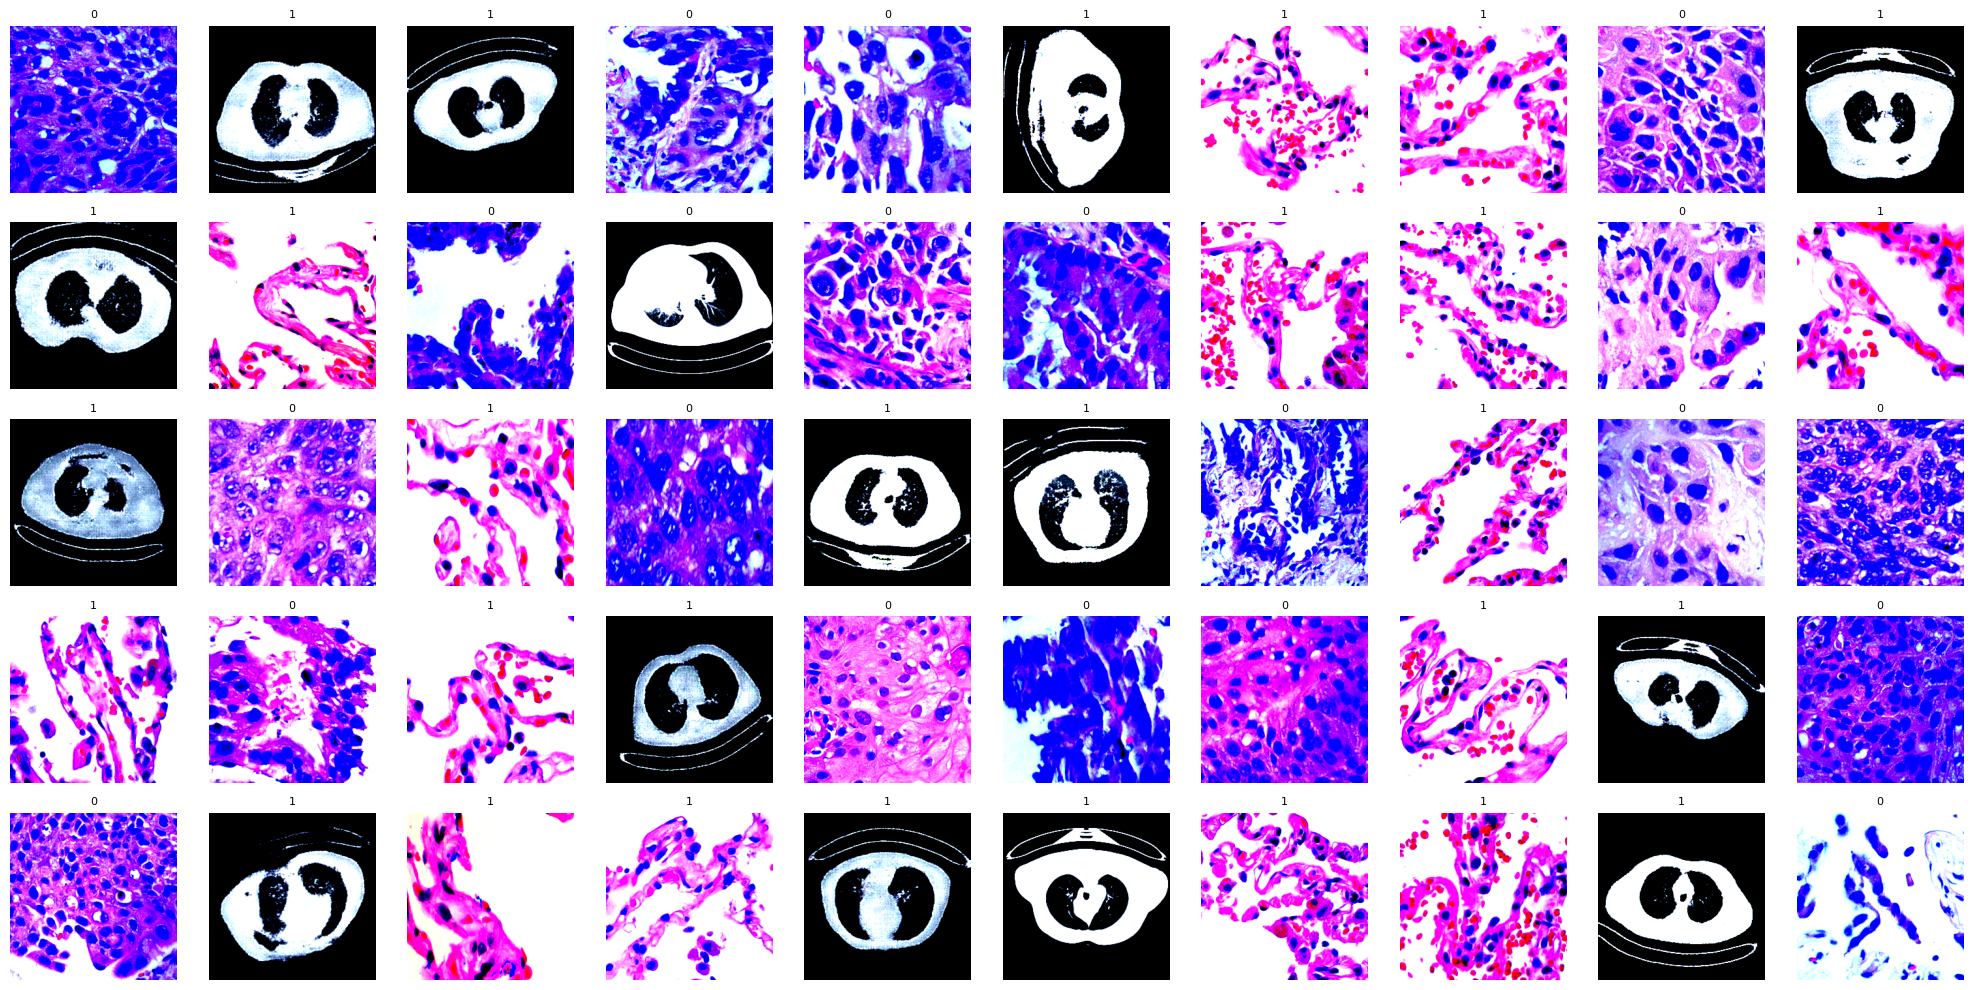

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take batches and flatten to 50 individual images
images = []
labels = []

# Collect 50 images
for batch_images, batch_labels in train_dataset:
    for i in range(len(batch_images)):
        images.append(batch_images[i])
        labels.append(batch_labels[i])
        if len(images) == 50:
            break
    if len(images) == 50:
        break

# Plot 50 images in a 10x5 grid
plt.figure(figsize=(20, 10))  # Adjust size as needed

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0).numpy())
    plt.title(f"{int(labels[i])}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


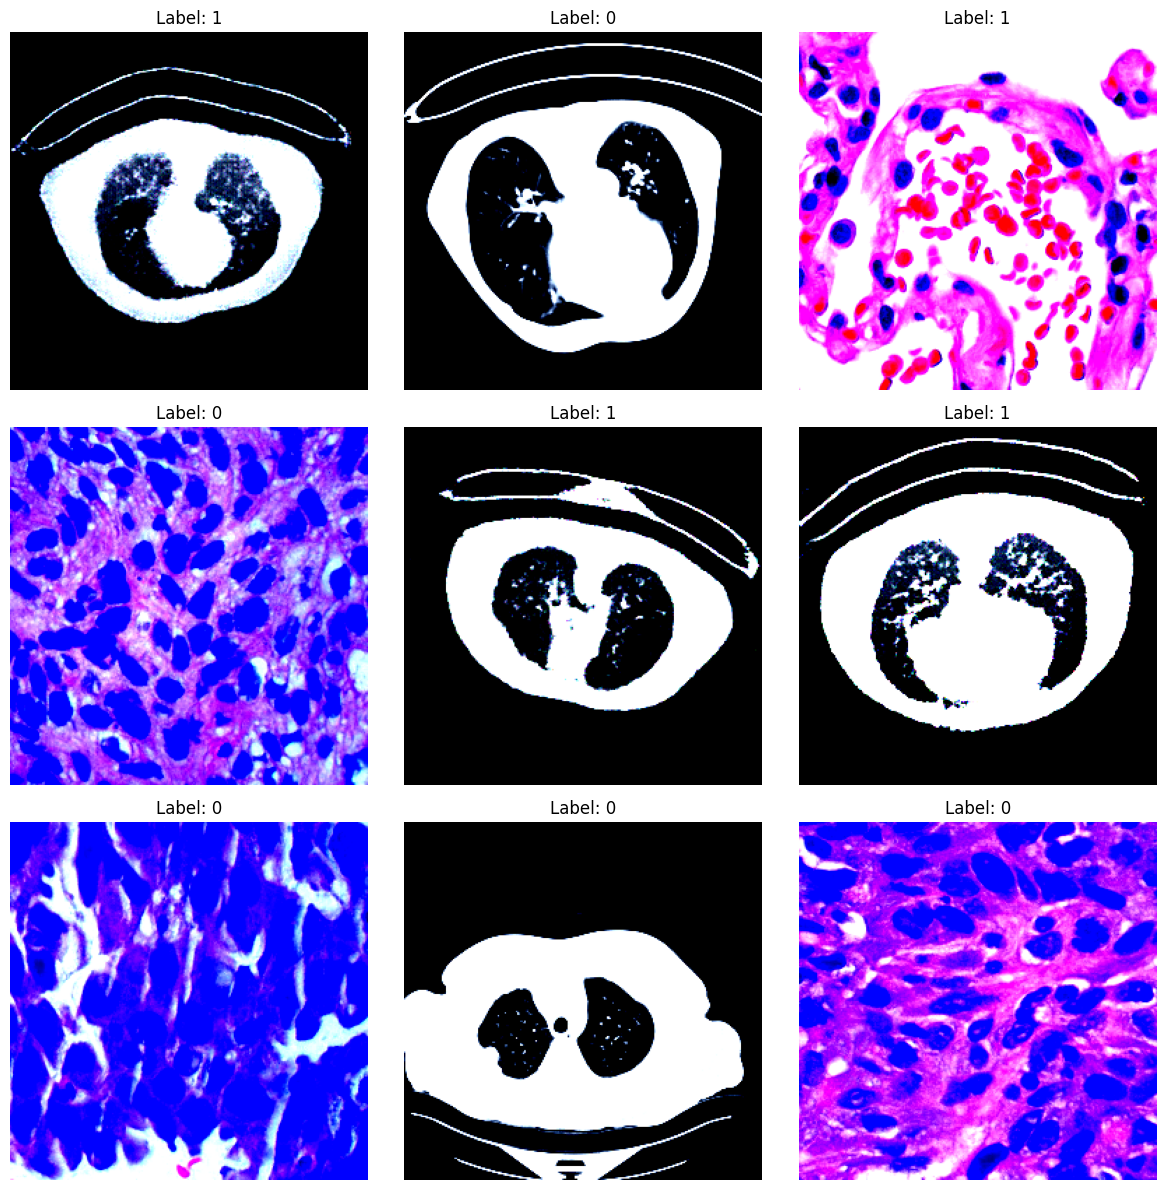

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take one batch from the dataset
for batch_images, batch_labels in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        img = batch_images[i]  # get i-th image from the batch
        label = batch_labels[i]

        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.clip_by_value(img, 0.0, 1.0).numpy())  # display image
        plt.title(f"Label: {int(label)}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [23]:
'''
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

# Step 1: Create the EfficientNetB0 model
def create_efficientnetB0_model(input_shape=(256, 256, 3), num_classes=1):
    # Load the pre-trained EfficientNetB0 model (excluding the top classification layers)
    base_model = EfficientNetB0(weights='imagenet', input_shape=input_shape, include_top=False)
    
    # Freeze the convolutional base (pre-trained weights)
    base_model.trainable = False
    
    # Create a custom model on top of EfficientNetB0
    model = models.Sequential([
        base_model,  # EfficientNetB0 as the base
        layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
        layers.Dense(512, activation='relu'),  # Fully connected layer
        layers.Dense(num_classes, activation='sigmoid')  # Output layer for binary classification
    ])
    
    return base_model, model

# Step 2: Get the model and base_model
base_model, model = create_efficientnetB0_model(input_shape=(256, 256, 3))

# Step 3: Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam optimizer with a low learning rate
    loss='binary_crossentropy',  # Binary crossentropy for binary classification
    metrics=['accuracy']  # Accuracy metric for evaluation
)

# Step 4: Set up Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best model weights after training stops
    verbose=1
)

# Step 5: Train the model with early stopping
history = model.fit(
    train_dataset,  # Training dataset with augmentation
    validation_data=val_dataset,  # Validation dataset
    epochs=10,  # Number of epochs
    verbose=1,  # Display progress bar
    callbacks=[early_stopping]  # Apply early stopping
)

# Step 6: Fine-tuning the model
# Unfreeze the last few layers of EfficientNetB0 for fine-tuning
base_model.trainable = True

# Fine-tune from a specific layer onward (e.g., unfreeze layers from the 100th layer)
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 7: Continue training (fine-tuning)
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1
)

# Step 8: Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Step 9: Plot training and validation accuracy/loss
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
'''

'\nimport tensorflow as tf\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.callbacks import EarlyStopping\nfrom tensorflow.keras.applications import EfficientNetB0\nimport matplotlib.pyplot as plt\n\n# Step 1: Create the EfficientNetB0 model\ndef create_efficientnetB0_model(input_shape=(256, 256, 3), num_classes=1):\n    # Load the pre-trained EfficientNetB0 model (excluding the top classification layers)\n    base_model = EfficientNetB0(weights=\'imagenet\', input_shape=input_shape, include_top=False)\n    \n    # Freeze the convolutional base (pre-trained weights)\n    base_model.trainable = False\n    \n    # Create a custom model on top of EfficientNetB0\n    model = models.Sequential([\n        base_model,  # EfficientNetB0 as the base\n        layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions\n        layers.Dense(512, activation=\'relu\'),  # Fully connected layer\n        layers.Dense(num_classes, activation=\'sigmoid\')  # Outp

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

# Step 1: Create the EfficientNetB0 model
def create_efficientnetB0_model(input_shape=(256, 256, 3), num_classes=1, learning_rate=0.0001):
    # Load the pre-trained EfficientNetB0 model (excluding the top classification layers)
    base_model = EfficientNetB0(weights='imagenet', input_shape=input_shape, include_top=False)
    
    # Freeze the convolutional base (pre-trained weights)
    base_model.trainable = False  # Start by freezing the base model
    
    # Create a custom model on top of EfficientNetB0
    model = models.Sequential([
        base_model,  # EfficientNetB0 as the base
        layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
        layers.Dense(512, activation='relu'),  # Fully connected layer
        layers.Dense(num_classes, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # Compile the model with the specified learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return base_model, model

# Step 2: Get the model and base_model
base_model, model = create_efficientnetB0_model(input_shape=(256, 256, 3))

# Step 3: Set up Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best model weights after training stops
    verbose=1
)

# Step 4: Example 1: Try a different optimizer and batch size
# Using SGD optimizer with momentum
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),  # Using SGD with momentum
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with a larger batch size
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=32,  # Larger batch size
    verbose=1,
    callbacks=[early_stopping]  # Apply early stopping
)

# Step 5: Example 2: Use a Learning Rate Scheduler (dynamic learning rate adjustment)
def scheduler(epoch, lr):
    if epoch < 5:
        return lr  # Keep learning rate the same for the first 5 epochs
    else:
        return lr * 0.5  # Reduce the learning rate after epoch 5

# Use Learning Rate Scheduler
callback = LearningRateScheduler(scheduler)

# Recompile the model before training with the learning rate scheduler
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),  # Using SGD again for demonstration
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with the Learning Rate Scheduler
history_lr_scheduler = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=32,  # Batch size
    callbacks=[callback, early_stopping],  # Include both the learning rate scheduler and early stopping
    verbose=1
)

# Step 6: Fine-tuning the model
# Unfreeze more layers of EfficientNetB0 for fine-tuning
base_model.trainable = True

# Fine-tune from a specific layer onward (e.g., unfreeze layers from the 50th layer)
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 7: Continue training (fine-tuning)
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1
)

# Step 8: Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Step 9: Plot training and validation accuracy/loss
# Plot the training and validation accuracy over epochs
plt.plot(history_lr_scheduler.history['accuracy'], label='Train Accuracy')
plt.plot(history_lr_scheduler.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_lr_scheduler.history['loss'], label='Train Loss')
plt.plot(history_lr_scheduler.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


'\nimport tensorflow as tf\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler\nfrom tensorflow.keras.applications import EfficientNetB0\nimport matplotlib.pyplot as plt\n\n# Step 1: Create the EfficientNetB0 model\ndef create_efficientnetB0_model(input_shape=(256, 256, 3), num_classes=1, learning_rate=0.0001):\n    # Load the pre-trained EfficientNetB0 model (excluding the top classification layers)\n    base_model = EfficientNetB0(weights=\'imagenet\', input_shape=input_shape, include_top=False)\n    \n    # Freeze the convolutional base (pre-trained weights)\n    base_model.trainable = False  # Start by freezing the base model\n    \n    # Create a custom model on top of EfficientNetB0\n    model = models.Sequential([\n        base_model,  # EfficientNetB0 as the base\n        layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions\n        layers.Dense(512, activation=\'relu\'),  # Fully c

In [25]:
#model.save('/kaggle/working/efficientnet_b0_lung_model.h5')


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# === Run Predictions ===
y_true = []
y_pred = []
y_prob = []

for x_batch, y_batch in test_dataset:
    probs = model.predict(x_batch).flatten()
    preds = (probs > 0.5).astype(int)

    y_true.extend(y_batch.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# === Metrics ===
accuracy = np.mean(y_true == y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auroc = roc_auc_score(y_true, y_prob)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Malignant", "Non-Malignant"], yticklabels=["Malignant", "Non-Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === Print Results ===
print("✅ Model Evaluation Metrics:")
print(f"Accuracy     : {accuracy * 100:.2f}%")
print(f"Macro F1     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"AUROC        : {auroc:.4f}")

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Malignant", "Non-Malignant"]))

'\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score\n\n# === Run Predictions ===\ny_true = []\ny_pred = []\ny_prob = []\n\nfor x_batch, y_batch in test_dataset:\n    probs = model.predict(x_batch).flatten()\n    preds = (probs > 0.5).astype(int)\n\n    y_true.extend(y_batch.numpy().astype(int))\n    y_pred.extend(preds)\n    y_prob.extend(probs)\n\ny_true = np.array(y_true)\ny_pred = np.array(y_pred)\ny_prob = np.array(y_prob)\n\n# === Metrics ===\naccuracy = np.mean(y_true == y_pred)\nf1 = f1_score(y_true, y_pred, average=\'macro\')\nprecision = precision_score(y_true, y_pred, average=\'macro\')\nrecall = recall_score(y_true, y_pred, average=\'macro\')\nauroc = roc_auc_score(y_true, y_prob)\n\n# === Confusion Matrix ===\ncm = confusion_matrix(y_true, y_pred)\nplt.figure(figsize=(6,5))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues

In [27]:
#!zip -r /kaggle/working/efficientnet_b0_lung_model.zip /kaggle/working/efficientnet_b0_lung_model.h5


**EfficientNetB1**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

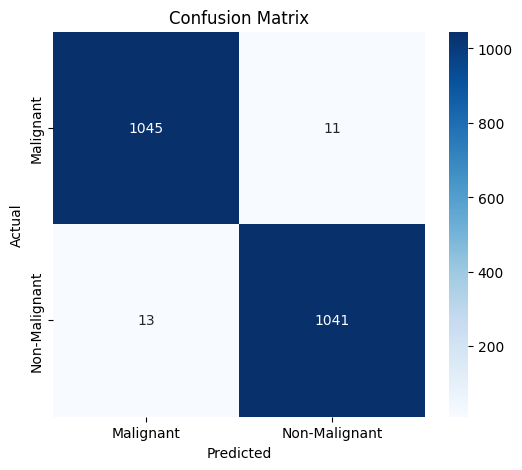

✅ Model Evaluation Metrics:
Accuracy     : 98.86%
Macro F1     : 0.9886
Precision    : 0.9886
Recall       : 0.9886
AUROC        : 0.9992

Classification Report:
               precision    recall  f1-score   support

    Malignant       0.99      0.99      0.99      1056
Non-Malignant       0.99      0.99      0.99      1054

     accuracy                           0.99      2110
    macro avg       0.99      0.99      0.99      2110
 weighted avg       0.99      0.99      0.99      2110



In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# === Run Predictions ===
y_true = []
y_pred = []
y_prob = []

for x_batch, y_batch in test_dataset:
    probs = model.predict(x_batch).flatten()
    preds = (probs > 0.5).astype(int)

    y_true.extend(y_batch.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# === Metrics ===
accuracy = np.mean(y_true == y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auroc = roc_auc_score(y_true, y_prob)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Malignant", "Non-Malignant"], yticklabels=["Malignant", "Non-Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === Print Results ===
print("✅ Model Evaluation Metrics:")
print(f"Accuracy     : {accuracy * 100:.2f}%")
print(f"Macro F1     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"AUROC        : {auroc:.4f}")

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Malignant", "Non-Malignant"]))
